# 차선인식

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

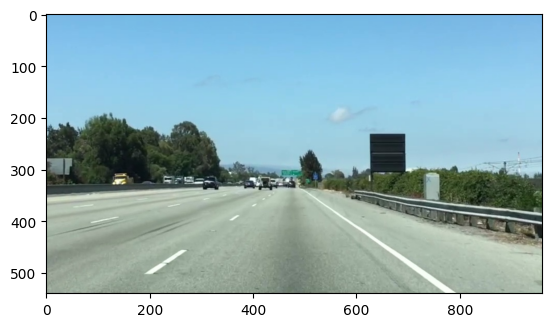

In [2]:
image = mpimg.imread('./data/test.jpg')
plt.imshow(image);


## Color Selection 
    - 색깔로 인식

Color Picker Tool로 해당 이미지 색상의 RGB 코드값 얻어오기
https://annystudio.com/software/colorpicker/#download

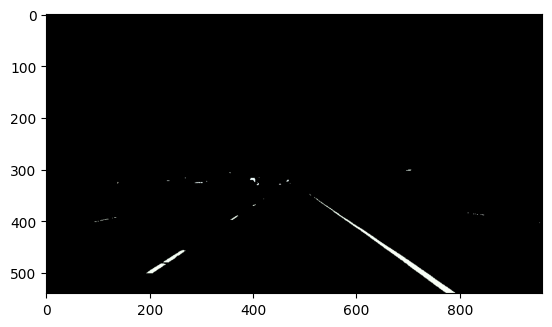

In [3]:
color_select= np.copy(image)

red_threshold =230
green_threshold =230
blue_threshold =230

color_threshold = ((image[:, :,0] < red_threshold) | (image[:,:,1] < green_threshold) | (image[:,:,2] < blue_threshold))

color_select[color_threshold] = [0,0,0]
plt.imshow(color_select)

## Region Selection
    -영역별 인식

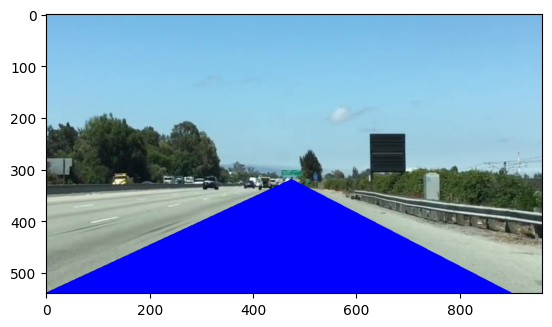

In [4]:
region_select = np.copy(image)

# todo
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

pts = np.array([left_bottom, right_bottom, apex])
cv2.fillPoly(region_select, [pts], color=[0, 0, 255])
plt.imshow(region_select)


## Color and Region Selection

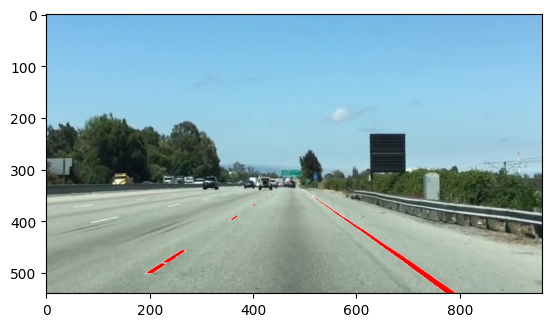

In [5]:
# 1. Color Selection
color_select = np.copy(image)

red_threshold = 230
green_threshold = 230
blue_threshold = 230

color_threshold = ((image[:, :, 0] < red_threshold) |
                  (image[:, :, 1] < green_threshold) |
                  (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]


# 2. Region Selection
region_select = np.copy(image)

# todo
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

pts = np.array([left_bottom, right_bottom, apex])
cv2.fillPoly(region_select, [pts], color=[0, 0, 255])

region_threshold = ((region_select[:, :, 0] == 0) &  # R channel
                   (region_select[:, :, 1] == 0) &  # G channel
                   (region_select[:, :, 2] == 255))  # B channel


# 3. Color Section + Region Selection
# color_thresholds : 차선(흰색)이 아닌 부분 True 설정
# region_threshold : 관심영역(region of interes, roi)에만 True 설정 
lane_select = np.copy(image)
lane_select[~color_threshold & region_threshold] = [255, 0, 0]
    
plt.imshow(lane_select)    

## Line Finding(white & yellow) 

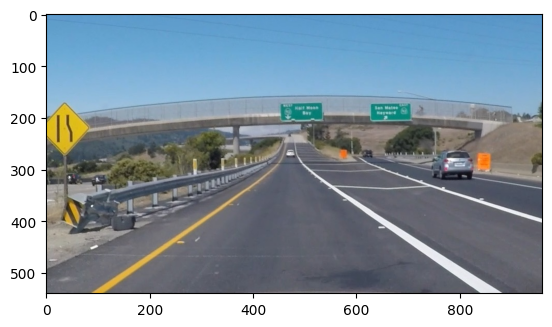

In [8]:
image = mpimg.imread('./data/exit-ramp.jpg')
plt.imshow(image);

### 1. gray scale 변환 

In [12]:
gray= cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)


### 2. gaussian blurring 

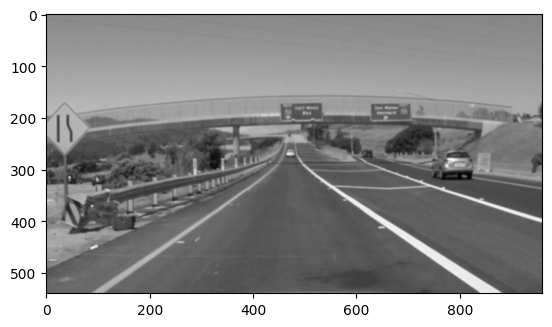

In [16]:
ksize = 5
blur_gray = cv2.GaussianBlur(gray, (ksize,ksize),0)
plt.imshow(blur_gray, cmap='gray')

### 3. edge detect

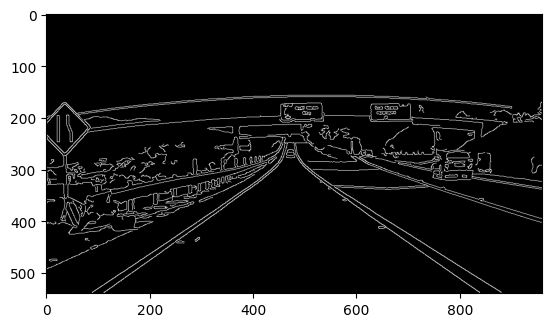

In [19]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold) 

plt.imshow(edges , cmap='gray')

In [47]:
edges.shape

(540, 960)

### 4. Regon Of Interest(관심영역)  selection 

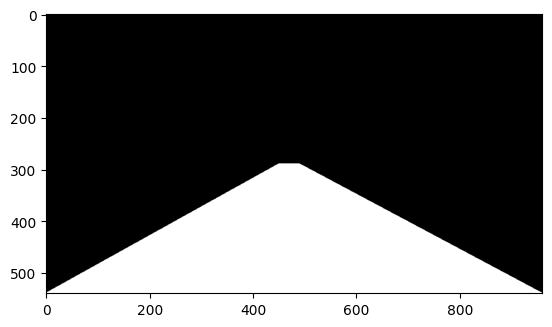

In [48]:
# 관심영역의 mask 구하기
x = edges.shape[1] 
y = edges.shape[0] 

pts = np.array([[(x//2)-30,(y//2)+20 ], [(x//2)+10,(y//2)+20 ], [x-1,y-1], [0,y-1]])
mask = np.zeros(edges.shape,edges.dtype) 
cv2.fillPoly(mask , [pts] , 255)
plt.imshow(mask, cmap='gray');


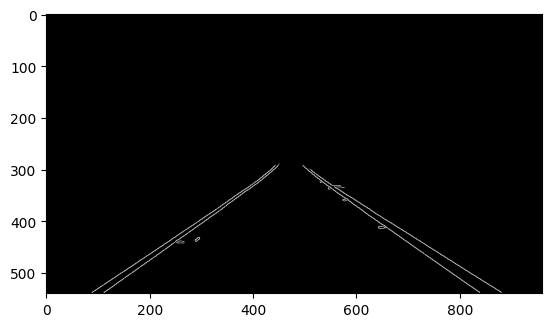

In [49]:
# mask 와 edge를  bitwise_and 하기 
masked_edges= cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap = 'gray');

### 5. line detect (with hough transform)

In [43]:
import math

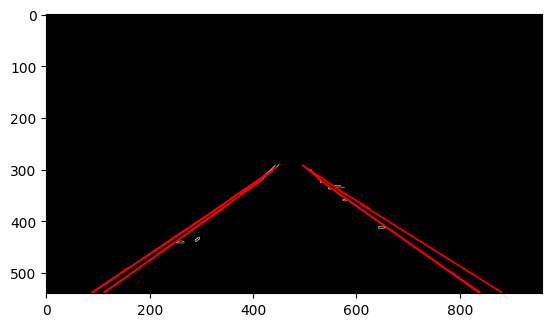

In [50]:
# 아직 완벽하게 차선이 검출되지 않음 -> hough transform 사용 

rho = 1
theta= math.pi /180
threshold = 30
minLineLength = 40
maxLineGap =20
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, 
                minLineLength=minLineLength, maxLineGap=maxLineGap)

# 직선 그릴 도화지그리기 
# dst = cv2.cvtColor(masked_edges ,cv2.COLOR_GRAY2BGR) # 직선 그릴 도화지(3차원) 

dst = np.dstack((masked_edges, masked_edges, masked_edges))

if lines is not None : 
    for i in range(len(lines)) : 
        line =lines[i][0]
        pt1 = line[0], line[1]
        pt2 = line[2], line[3]
        cv2.line(dst, pt1, pt2, (255,0,0), 2, cv2.LINE_AA) 

plt.imshow(dst);

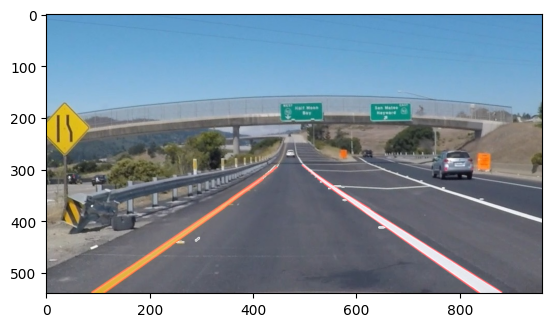

In [55]:
# 원본과 검출된 직선 병합
# result = cv2.add(image, dst) 
result = cv2.addWeighted(image, 1, dst, 0.8, 0) 

plt.imshow(result);

## Pipeline
- Canny Detection -> ROI Selection -> Hough Transform

걍 다 합치면 됨 